In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [36]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)


In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
lr = 2e-4
z_dim = 100
image_dim =28 * 28 * 1
batch_size = 64
num_epochs = 50

In [42]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn(64, z_dim).to(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])


In [43]:
dataset = datasets.MNIST(root="dataset/", transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [44]:
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [46]:
import os
os.makedirs("/mnt/data/gan_generated", exist_ok=True)

In [47]:
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, image_dim).to(device)
        batch_size = real.shape[0]

        # Discriminator
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2

        disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        # Generator
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))

        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        G_losses.append(lossG.item())
        D_losses.append(lossD.item())

        if batch_idx % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {batch_idx}/{len(loader)}] "
                  f"Loss D: {lossD:.4f}, Loss G: {lossG:.4f}")

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        gen.eval()
        with torch.no_grad():
            fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
            fake = fake * 0.5 + 0.5
            torchvision.utils.save_image(fake, f"/mnt/data/gan_generated/fake_epoch_{epoch}.png")
        gen.train()


[Epoch 0/50] [Batch 0/1875] Loss D: 0.5199, Loss G: 0.8823
[Epoch 0/50] [Batch 100/1875] Loss D: 0.5273, Loss G: 1.3384
[Epoch 0/50] [Batch 200/1875] Loss D: 0.5513, Loss G: 1.0766
[Epoch 0/50] [Batch 300/1875] Loss D: 0.5016, Loss G: 1.2331
[Epoch 0/50] [Batch 400/1875] Loss D: 0.5061, Loss G: 2.1393
[Epoch 0/50] [Batch 500/1875] Loss D: 0.7169, Loss G: 2.2645
[Epoch 0/50] [Batch 600/1875] Loss D: 1.0546, Loss G: 3.0973
[Epoch 0/50] [Batch 700/1875] Loss D: 0.5785, Loss G: 2.1722
[Epoch 0/50] [Batch 800/1875] Loss D: 0.6677, Loss G: 0.8528
[Epoch 0/50] [Batch 900/1875] Loss D: 0.4724, Loss G: 1.7760
[Epoch 0/50] [Batch 1000/1875] Loss D: 0.4958, Loss G: 1.1105
[Epoch 0/50] [Batch 1100/1875] Loss D: 0.5785, Loss G: 2.2988
[Epoch 0/50] [Batch 1200/1875] Loss D: 0.4194, Loss G: 1.6948
[Epoch 0/50] [Batch 1300/1875] Loss D: 0.5106, Loss G: 1.0289
[Epoch 0/50] [Batch 1400/1875] Loss D: 0.5092, Loss G: 1.3100
[Epoch 0/50] [Batch 1500/1875] Loss D: 0.5637, Loss G: 0.8689
[Epoch 0/50] [Batch 

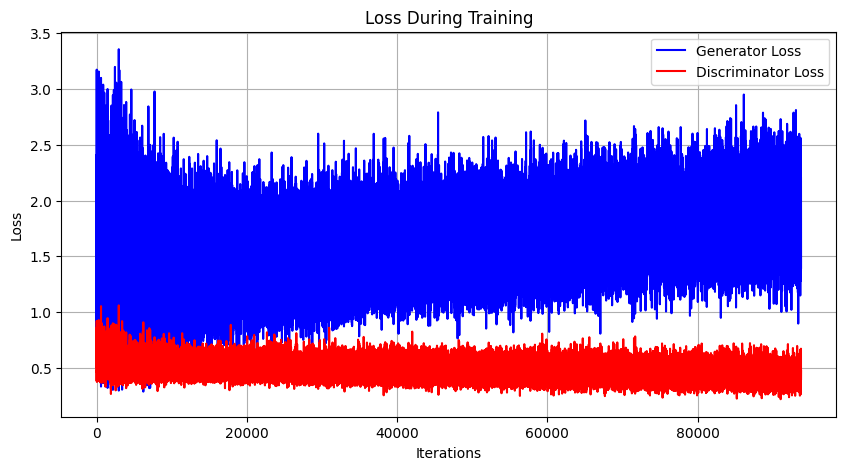

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("Loss During Training")
plt.plot(G_losses, label="Generator Loss", color='blue')
plt.plot(D_losses, label="Discriminator Loss", color='red')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [49]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

gen.eval()
with torch.no_grad():
    fake_images = gen(fixed_noise).reshape(-1, 1, 28, 28).cpu()


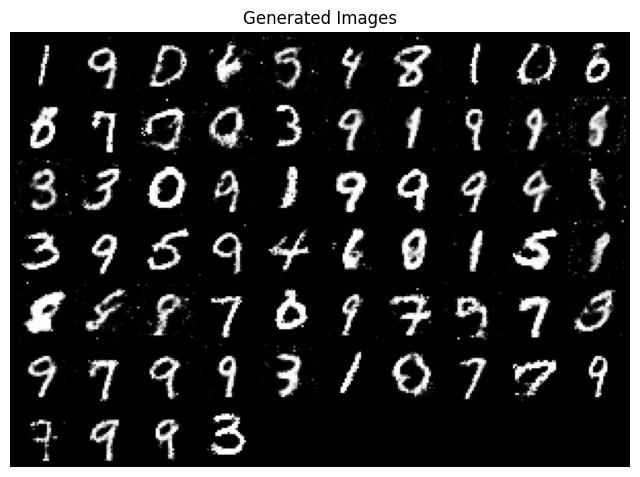

In [50]:
img_grid = vutils.make_grid(fake_images, normalize=True, nrow=10)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(img_grid.permute(1, 2, 0))  # (C, H, W) → (H, W, C)
plt.show()
